<h2>Introduction</h2>
(last update: March 18, 2025)

<div>
    This is first notebook in segmentation project series.<br>
    Demonstrate different clustering algorithms.
</div>

In [1]:
#from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import datetime

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [83]:
from yellowbrick.cluster import KElbowVisualizer

In [84]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

<div>
    <h5>Download dataset (first time access)</h5>
    <p>Comment out all lines for kaggle-dataset download, when running notebook next time.</p>
</div>

In [ ]:
# create instance of KaggleApi
#api = KaggleApi()
# authentication with api-key
#api.authenticate()
# download the dataset
#api.dataset_download_files('imakash3011/customer-personality-analysis', path='./data/', unzip=True)

In [3]:
#read the tab-separated file
data = pd.read_csv('data/marketing_campaign.csv', sep="\t")

In [ ]:
data.head(3)

In [4]:
#basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
#list of all categorical column-names
categorical_colnames = data.select_dtypes(include=['object']).columns.tolist()
categorical_colnames

['Education', 'Marital_Status', 'Dt_Customer']

In [6]:
#remove "dt_customer" from the list- those are dates when customers joined
#inplace removal
categorical_colnames.remove('Dt_Customer')

In [7]:
#find all unique values in each column
for colname in categorical_colnames:
    print(f"{data[colname].value_counts()}")
    print()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64



In [8]:
#Numerical columns with important data
num_columns = ['Income', 'Kidhome', 'Teenhome','Recency','MntWines','MntFruits','MntMeatProducts', 'MntFishProducts',
              'MntSweetProducts','MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
              'NumWebVisitsMonth']

In [ ]:
#stat-description of these columns
#data[num_columns].describe().drop(["count", "25%", "75%"])

### 2. Data Cleaning:

1. Missing values- Income column has missing values; those handful of rows will be dropped.
2. Incorrect data- Dates are in string format; will be converted to date-time format.
3. Categorical features- they will be encoded in numerical form.

#### 2.1 Missing values

In [9]:
#remove missing values
data = data.dropna()

In [10]:
#check total number of observations left
print(f"total rows in dataframe now: {len(data)}")

total rows in dataframe now: 2216


#### 2.2 Date of Joining column

In [11]:
#check type
type(data.Dt_Customer[1])

str

In [12]:
#convert the column to date-time
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

In [13]:
data['Dt_Customer'].describe()

count                             2216
mean     2013-07-10 11:29:27.509025280
min                2012-07-30 00:00:00
25%                2013-01-16 00:00:00
50%                2013-07-08 12:00:00
75%                2013-12-31 00:00:00
max                2014-06-29 00:00:00
Name: Dt_Customer, dtype: object

In [14]:
dates = []

In [15]:
for i in data['Dt_Customer']:
    #extract only the date part from date-time format of column
    i = i.date()
    dates.append(i)
#Earliest and most recent date in the dataset
print("Newest date of customer enrollment:", max(dates))
print("Oldest date of customer enrollment:", min(dates))

Newest date of customer enrollment: 2014-06-29
Oldest date of customer enrollment: 2012-07-30


Now, I'll create a new feature <b>"Customer_For"</b> out of this <b>"Dt_Customer"</b>, which contains num. of days a customer has been shopping at this store (with respect to the most recent date in the dataset).

In [16]:
#most recent date in database
recent_date = max(dates)

In [17]:
#Creating "Customer_for" features
#customer-for-xxx-number-of-days

#list to store number of days for each customer
days = []
for i in dates:
    #this wont give a date, but a timedelta object.
    num_of_days = recent_date - i
    #add this to the days-list
    days.append(num_of_days)

#demo of what the days list values type
print("Number of days is of type datetime right now: ", days[0:2])

Number of days is of type datetime right now:  [datetime.timedelta(days=663), datetime.timedelta(days=113)]


The "number of days" obtained above are in datetime's timedelta format instead of integer.  
In the following code chunk, <b><code>column-name.dt.days</code></b> extracts the "days" part and <b><code>pd.to_numeric()</code></b> converts it to integer format.

In [18]:
#Add this list days-count to the dataframe
data['Customer_For'] = days
#values are time-delta objects, extract days out from them
data['Customer_For'] = data['Customer_For'].dt.days
#Convert to numeric type
data['Customer_For'] = pd.to_numeric(data['Customer_For'])

In [19]:
data[['ID', 'Dt_Customer', 'Customer_For']].head(3)

,ID,Dt_Customer,Customer_For
0,5524,2012-09-04,663
1,2174,2014-03-08,113
2,4141,2013-08-21,312


#### 2.3 Create New Features

##### A. Age of customers

In [20]:
type(recent_date.year)

int

In [21]:
#age will be calculated from 2014, the most recent date in dataset
age = []
recent_year = recent_date.year
for i in data['Year_Birth']:
    customer_age = recent_year - i
    age.append(customer_age)

In [22]:
#add this list to dataframe
data['customer_age'] = age
print("maximum age", max(data.customer_age))
print("minimum age", min(data.customer_age))

maximum age 121
minimum age 18


Maximum age of 121 seems bizarre.  
Let's have a look at the age-distribution of all customers.  
These discrepancies will be corrected in upcoming sections.

In [23]:
data['customer_age'].describe()

count    2216.000000
mean       45.179603
std        11.985554
min        18.000000
25%        37.000000
50%        44.000000
75%        55.000000
max       121.000000
Name: customer_age, dtype: float64

In [24]:
#finding out the 99th percentile of age
data['customer_age'].quantile(0.99)

np.float64(69.0)

99% of customers in this dataset are below the age of 69.  
There, definitely are some outliers in the dataset.

<h5>b. Total amount spent by each customer in 2 years</h5>

In [25]:
#see names of all columns starting with "Mnt"
data.columns[data.columns.str.startswith('Mnt')]

Index(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds'],
      dtype='object')

In [26]:
#add values of all column starting with "Mnt"
data['total_spent'] = data.loc[:, data.columns.str.startswith('Mnt')].sum(axis=1)

In [27]:
data['total_spent'].describe()

count    2216.000000
mean      607.075361
std       602.900476
min         5.000000
25%        69.000000
50%       396.500000
75%      1048.000000
max      2525.000000
Name: total_spent, dtype: float64

<h5>c. Living situation from marital status of customer</h5>

In [28]:
#all unique values in the marital status column
data['Marital_Status'].value_counts()

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

"Married" and "Together" values will be replaced with "Partner".  
All other values will be replaced with "Alone".  
This is being done to simplify the living-status of customer.

In [29]:
data['living_with'] = data['Marital_Status'].replace({'Married':'Partner', 
                                                         'Together':'Partner',
                                                        'Single':'Alone',
                                                        'Divorced':'Alone',
                                                        'Widow':'Alone',
                                                        'Absurd':'Alone',
                                                        'YOLO':'Alone'}
                                                       )

In [30]:
data['living_with'].value_counts()

living_with
Partner    1430
Alone       786
Name: count, dtype: int64

<h5>d. Total children in house</h5>

In [31]:
data['children'] = data['Kidhome'] + data['Teenhome']

In [32]:
data['children'].value_counts()

children
1    1117
0     633
2     416
3      50
Name: count, dtype: int64

<h5>e. Total members in family</h5>

In [33]:
data['family_size'] = data['living_with'].replace({'Partner':2, 'Alone':1}).infer_objects(copy=False) + data['children']

C:\Users\shefa\AppData\Local\Temp\ipykernel_8160\2449182206.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['family_size'] = data['living_with'].replace({'Partner':2, 'Alone':1}).infer_objects(copy=False) + data['children']


In [34]:
data['family_size'].value_counts()

family_size
3    880
2    757
4    296
1    252
5     31
Name: count, dtype: int64

<h5>f. Feature indicating parenthoood</h5>

In [35]:
#1 for parenthood, 0 for none
data['parenthood'] = (data['children'] > 0).astype(int)

In [36]:
data[['children', 'parenthood']].head(4)

,children,parenthood
0,0,0
1,2,1
2,0,0
3,1,1


<h5>g. Create only 3 categories for Education level</h5>

In [37]:
data['Education'].value_counts()

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64

In [38]:
data['edu_level'] = data['Education'].replace({'Basic':'Undergraduate', 
                                              '2n Cycle': 'Undergraduate',
                                              'Graduation':'Graduate',
                                              'Master':'Postgraduate',
                                              'PhD':'Postgraduate'})

<h5>h. Rename some columns</h5>

In [39]:
data.columns[data.columns.str.startswith('Mnt')]

Index(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds'],
      dtype='object')

In [40]:
data = data.rename(columns={'MntWines':'Wine', 'MntFruits':'Fruits', 'MntMeatProducts':'Meat',
                   'MntFishProducts':'Fish','MntSweetProducts':'Sweets', 'MntGoldProds':'Gold'})

<h5>i. Drop redundant features</h5>

In [ ]:
data.columns

In [41]:
cols_to_drop = ['Year_Birth', 'Marital_Status', 'Dt_Customer', 'Z_CostContact','Z_Revenue', 'ID', 'Education']
#remove these columns from dataframe
data = data.drop(cols_to_drop, axis=1)

In [42]:
data['Complain'].value_counts()

Complain
0    2195
1      21
Name: count, dtype: int64

<h4>4. Visual Analysis of features</h4>

In [44]:
numerical_cols = ['customer_age', 'Customer_For', 'Income','total_spent', 'Recency']

In [45]:
data[numerical_cols].describe()

,customer_age,Customer_For,Income,total_spent,Recency
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,45.179603,353.521209,52247.251354,607.075361,49.012635
std,11.985554,202.434667,25173.076661,602.900476,28.948352
min,18.000000,0.000000,1730.000000,5.000000,0.000000
25%,37.000000,180.000000,35303.000000,69.000000,24.000000
50%,44.000000,355.500000,51381.500000,396.500000,49.000000
75%,55.000000,529.000000,68522.000000,1048.000000,74.000000
max,121.000000,699.000000,666666.000000,2525.000000,99.000000


Max value in income and age of customers seems way off from the median and 75th percentile.  
A visual analysis might help detect outliers.

In [46]:
#features to plot
columns_to_plot = ['customer_age', 'Income', 'parenthood']

<Figure size 640x480 with 0 Axes>

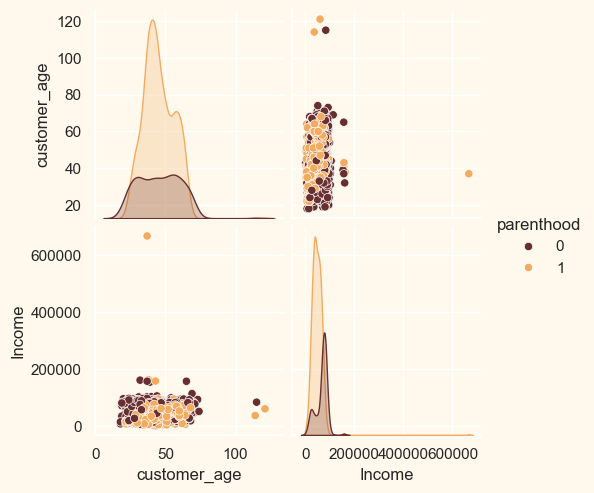

In [47]:
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
#pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
#cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

plt.figure()
sns.pairplot(data[columns_to_plot], hue='parenthood',
             palette= (["#682F2F","#F3AB60"]))
plt.show()

In [48]:
#Drop rows with outliers

data = data[(data["customer_age"]<90)]

In [49]:
data = data[(data['Income'] < 600000)]

In [50]:
data.shape

(2212, 30)

<h3>3. Data Preprocessing</h3>

In this section, I'll preprocess the features to perform clustering operations.

Following steps will be taken in this section:
<ul>
    <li>Feature encoding of categorical columns.</li>
    <li>Feature scaling using standard-scalar.</li>
    <li>Create subset dataframe for dimensionality reduction.</li>
</ul>

In [51]:
s = (data.dtypes == 'object')

In [53]:
s[s].index

Index(['living_with', 'edu_level'], dtype='object')

In [54]:
#categorical columns
cat_columns = list(s[s].index)

In [55]:
cat_columns

['living_with', 'edu_level']

In [56]:
#instantiate Label-Encoder
le = LabelEncoder()

In [57]:
#dictionary to store values and their encoding for each column
encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    data[f"{col}_coded"] = le.fit_transform(data[col])
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [58]:
#view the numbers associated to each category in each column
for key in encoders:
    print(f"{key}: {encoders[key]}")

living_with: {'Alone': np.int64(0), 'Partner': np.int64(1)}
edu_level: {'Graduate': np.int64(0), 'Postgraduate': np.int64(1), 'Undergraduate': np.int64(2)}


In [59]:
#make a copy of the dataframe
data2 = data.copy()

In [60]:
data2.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'Wine', 'Fruits', 'Meat',
       'Fish', 'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Customer_For', 'customer_age',
       'total_spent', 'living_with', 'children', 'family_size', 'parenthood',
       'edu_level', 'living_with_coded', 'edu_level_coded'],
      dtype='object')

In [61]:
#create subset of the dataset by removing promotion/acceptance colummns
accepted_cols = list(data.columns[data.columns.str.contains('Accepted', case=False)])
drop_columns = accepted_cols + ['Complain', 'Response', 'living_with', 'edu_level']
#remove the columns
data_subset = data2.drop(drop_columns, axis=1)

In [62]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2212 non-null   float64
 1   Kidhome              2212 non-null   int64  
 2   Teenhome             2212 non-null   int64  
 3   Recency              2212 non-null   int64  
 4   Wine                 2212 non-null   int64  
 5   Fruits               2212 non-null   int64  
 6   Meat                 2212 non-null   int64  
 7   Fish                 2212 non-null   int64  
 8   Sweets               2212 non-null   int64  
 9   Gold                 2212 non-null   int64  
 10  NumDealsPurchases    2212 non-null   int64  
 11  NumWebPurchases      2212 non-null   int64  
 12  NumCatalogPurchases  2212 non-null   int64  
 13  NumStorePurchases    2212 non-null   int64  
 14  NumWebVisitsMonth    2212 non-null   int64  
 15  Customer_For         2212 non-null   int64 

In [63]:
##Standardize the subset
stan_scaler = StandardScaler()
stan_scaler.fit(data_subset)
scaled_ds = pd.DataFrame(stan_scaler.transform(data_subset), columns=data_subset.columns)
print("All features scaled")

All features scaled


In [64]:
print("Dataframe to be used for future modelling")
scaled_ds.head(4)

Dataframe to be used for future modelling


,Income,Kidhome,Teenhome,Recency,Wine,Fruits,Meat,Fish,Sweets,Gold,...,NumStorePurchases,NumWebVisitsMonth,Customer_For,customer_age,total_spent,children,family_size,parenthood,living_with_coded,edu_level_coded
0,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,...,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.264598,-1.758359,-1.581139,-1.349603,-0.893586
1,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,...,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,1.404572,0.449070,0.632456,-1.349603,-0.893586
2,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,...,1.290224,-0.544908,-0.206048,0.334530,0.280110,-1.264598,-0.654644,-1.581139,0.740959,-0.893586
3,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,...,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.069987,0.449070,0.632456,0.740959,-0.893586


<h4>Check for correlation between features</h4>

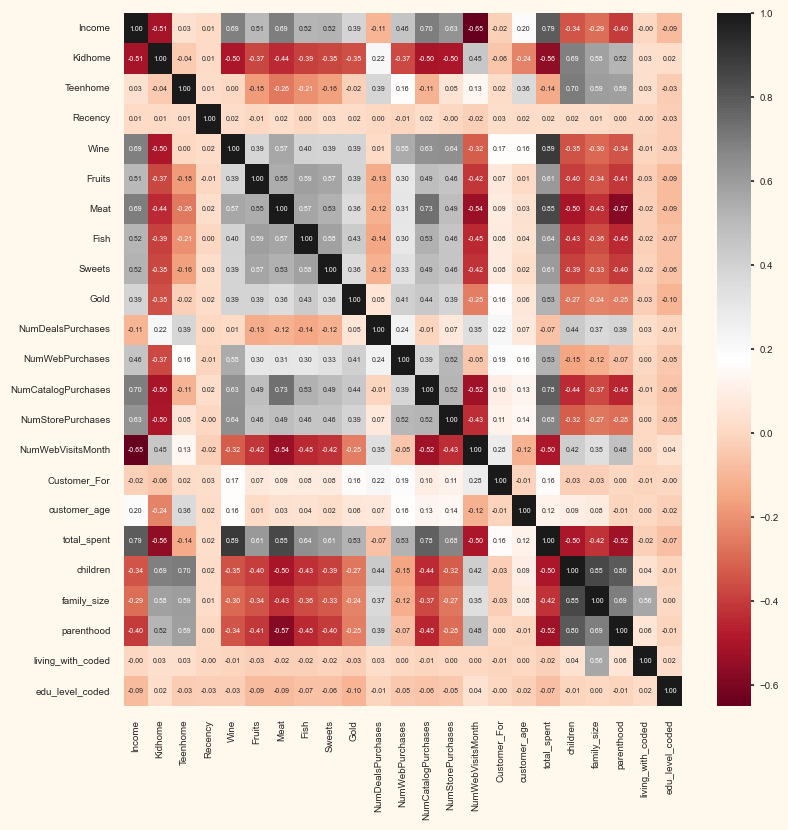

In [67]:
plt.figure(figsize = (9,9))
ax = sns.heatmap(data_subset.corr(), annot=True, cmap='RdGy', fmt='.2f', annot_kws={'size':5})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=7, size=2.5)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

<h3>Dimensionality Reduction via PCA</h3>

I have to reduce the number of features to 3 using Principal Component analysis.

In [68]:
pca = PCA(n_components = 3)

In [69]:
pca.fit(scaled_ds)

PCA(n_components=3)

In [70]:
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns = (['col1', 'col2', 'col3']))

In [73]:
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-3.212219e-17,2.878602,-5.978124,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,0.000000e+00,1.709469,-4.194757,-1.323929,-0.173721,1.234851,6.168189
col3,2212.0,3.212219e-18,1.231687,-3.625248,-0.853713,-0.050842,0.863974,6.750458


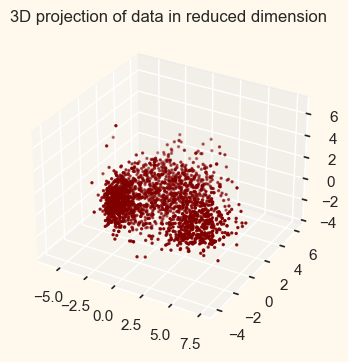

In [78]:
#3D projection of data in reduced dimension
x = PCA_ds['col1']
y = PCA_ds['col2']
z = PCA_ds['col3']
#plot
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c='maroon', marker='o', s=2)
ax.set_title('3D projection of data in reduced dimension')
plt.show()

<h3>Clustering</h3>

Steps to be performed in clustering:  
1. Elbow method- to determine number of clusters to be formed.
2. Clustering process via Agglomerative Clustering.
3. Analysing clusters formed through scatter plots.

<h4>3.1 Decide on number of clusters</h4>

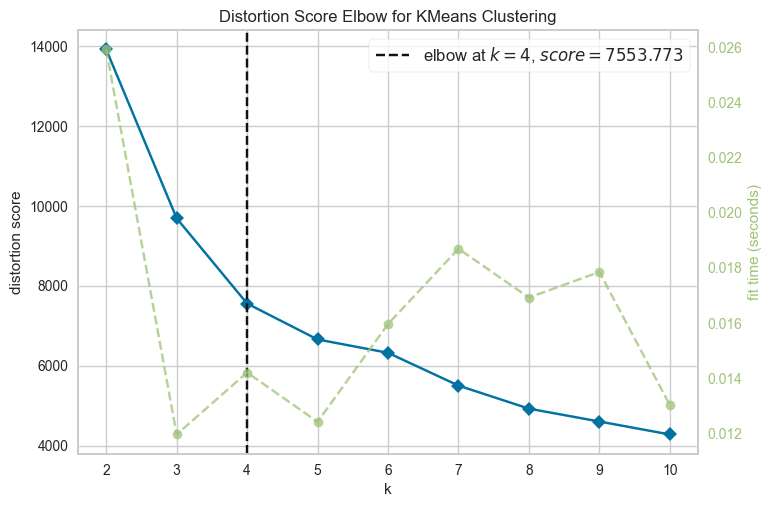

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
#apply Elbow method
Elbow_M = KElbowVisualizer(KMeans(), n=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

Graph above shows that 4 will an optimal number of clusters.  
Below agglomerative clustering has been performed on our data using 4 clusters.